In [2]:

import numpy as np
import pandas as pd
import scipy
import scipy.ndimage

from matplotlib import pyplot as plt



In [3]:
raw = pd.read_csv('../data/raw/f_7746236261c73c8a.csv', delimiter=';', decimal=',')

# Разделение набора данных на обучающую и тестовую выборки

Для обучения моделей будут использоваться данные первых 5 лет наблюдений (2010-2014). Наблюдения за последний год (2015) будут использованы для оценки точности прогнозирования. 

In [4]:
train = raw.iloc[:365 * 5 + 1] # 2012 - високосный год => в обучающую выборку попадает лишний день
test = raw.iloc[365 * 5 + 1:]

print('train:', len(train), '\ntest:', len(test))

train: 1826 
test: 365


# Предварительная обработка данных

Cтандартизация:

$Z_i = \dfrac{X_i - \mu}{\sigma}$, 

где $\mu$ - среднее значение по выборке, $\sigma$ - стандартное отклонение

In [5]:
def standardize(data, std_params=None):
    if std_params:
        mean, std = std_params
    else:
        mean = data.mean()
        std = data.std()
        
        std_params = [mean, std]
        
    data_std = (data - mean) / std
        
    return data_std, std_params

## Энергопотребление 
числовой признак
* вычисляется среднее значение за сутки
* применяется стандартизация

In [6]:
def get_e(data):
    e_labels = ['E' + str(i) for i in range(1, 25)]
    
    return data[e_labels]

In [7]:
def preprocess_e(data, std_params=None):
    e = get_e(data)
    
    e_avg = e.mean(axis=1)
    
    e_avg_std, std_params = standardize(e_avg, std_params)
    
    return e_avg, e_avg_std, std_params

In [8]:
e_avg, e_avg_std, e_params = preprocess_e(train)

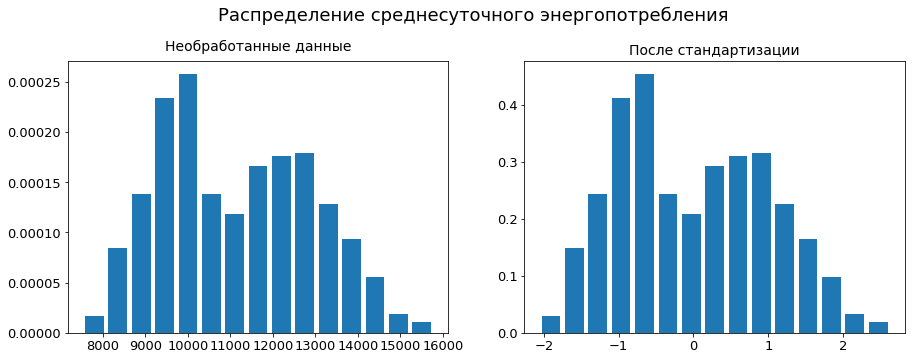

In [9]:
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('figure', titlesize=18)

fig, axs = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Распределение среднесуточного энергопотребления', y=1.03)

axs[0].hist(e_avg, density=True, bins=15, rwidth=0.8)
axs[0].set_title('Необработанные данные', pad=10)

axs[1].hist(e_avg_std, density=True, bins=15, rwidth=0.8)
axs[1].set_title('После стандартизации')

plt.show()

## Температура
числовой признак
* вычисляется среднее значение за сутки
* применяется стандартизация 

In [10]:
def get_t(data):
    t_labels = ['T' + str(i) for i in range(1, 25)]
    
    return data[t_labels]

In [11]:
def preprocess_t(data, std_params=None):
    t = get_t(data)

    t_avg = t.mean(axis=1)
    
    t_avg_std, std_params = standardize(t_avg, std_params)
    
    return t_avg, t_avg_std, std_params

In [12]:
t_avg, t_avg_std, t_params = preprocess_t(train)

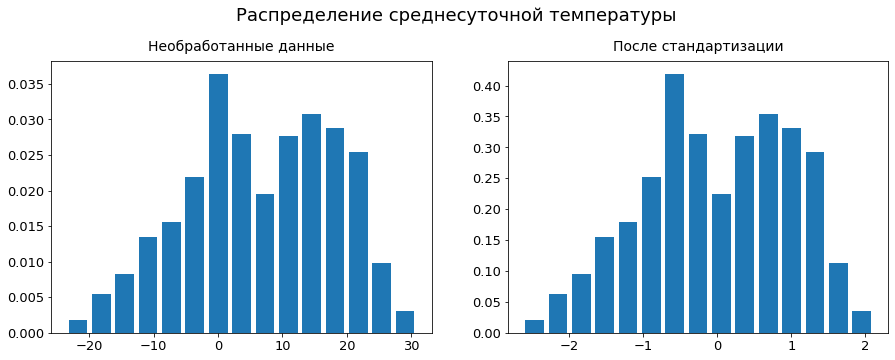

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Распределение среднесуточной температуры', y=1.03)

axs[0].hist(t_avg, density=True, bins=15, rwidth=0.8)
axs[0].set_title('Необработанные данные', pad=10)

axs[1].hist(t_avg_std, density=True, bins=15, rwidth=0.8)
axs[1].set_title('После стандартизации', pad=10)

plt.show()

## FT (?)
числовой признак
* применяется стандартизация

In [14]:
def preprocess_ft(data, std_params=None):    
    ft_labels = ['FT' + str(i) for i in range(4, 23, 6)]
    
    ft = data[ft_labels]
    ft_std = pd.DataFrame()
    
    if std_params is None:
        std_params = [None] * len(ft_labels)
        
    for i in range(len(ft_labels)):
        ft_std[ft_labels[i]], std_params[i] = standardize(ft[ft_labels[i]], std_params[i])
        
    return ft, ft_std, std_params

In [15]:
ft, ft_std, ft_params = preprocess_ft(train)

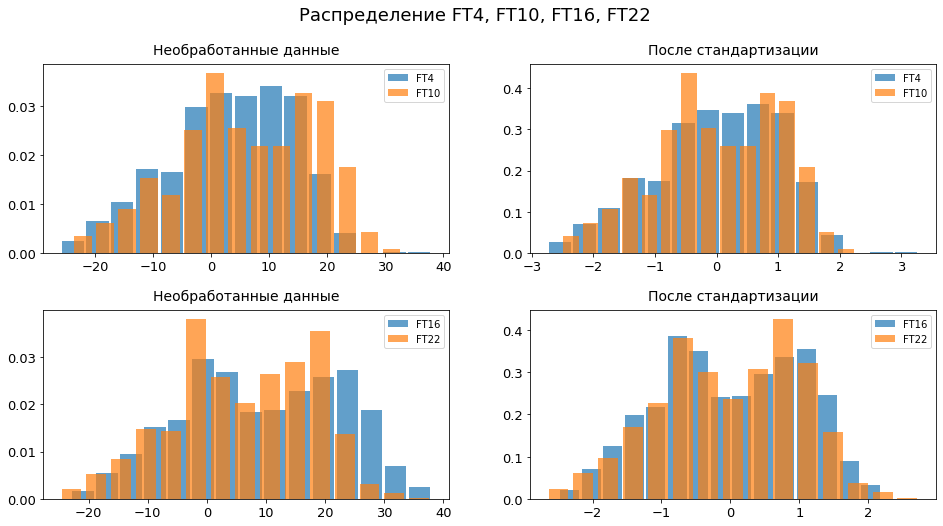

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16,8))
fig.suptitle('Распределение FT4, FT10, FT16, FT22')
fig.subplots_adjust(hspace=0.3)

axs[0][0].hist(ft['FT4'], density=True, bins=15, rwidth=0.9, alpha=0.7, label='FT4')
axs[0][0].hist(ft['FT10'], density=True, bins=15, rwidth=0.8, alpha=0.7, label='FT10')
axs[1][0].hist(ft['FT16'], density=True, bins=15, rwidth=0.9, alpha=0.7, label='FT16')
axs[1][0].hist(ft['FT22'], density=True, bins=15, rwidth=0.8, alpha=0.7, label='FT22')
axs[0][0].legend()
axs[1][0].legend()
axs[0][0].set_title('Необработанные данные', pad=10)
axs[1][0].set_title('Необработанные данные', pad=10)

axs[0][1].hist(ft_std['FT4'], density=True, bins=15, rwidth=0.9, alpha=0.7, label='FT4')
axs[0][1].hist(ft_std['FT10'], density=True, bins=15, rwidth=0.8, alpha=0.7, label='FT10')
axs[1][1].hist(ft_std['FT16'], density=True, bins=15, rwidth=0.9, alpha=0.7, label='FT16')
axs[1][1].hist(ft_std['FT22'], density=True, bins=15, rwidth=0.8, alpha=0.7, label='FT22')
axs[0][1].legend()
axs[1][1].legend()
axs[0][1].set_title('После стандартизации', pad=10)
axs[1][1].set_title('После стандартизации', pad=10)


plt.show()

## День недели
циклический признак

Применяется алгоритм кодирования циклических признаков (cyclic feature encoding). Возможные значения признака располагаются на окружности, для каждого из них вычисляется синус и косинус соответствующего угла. Таким образом, значение разбивается на две компоненты по формулам:

$X_{sin} = \sin(\dfrac{2 \pi X}{\max(X)})$

$X_{cos} = \cos(\dfrac{2 \pi X}{\max(X)})$

In [17]:
def encode_cyclic(data, col_name):
    res = pd.DataFrame()
    
    res[col_name + '_sin'] = np.sin(2 * np.pi * data / data.max())
    res[col_name + '_cos'] = np.cos(2 * np.pi * data / data.max())
    
    return res

In [18]:
def preprocess_dow(data):
    return encode_cyclic(data['Day of week'], 'DoW')

In [19]:
dow = preprocess_dow(train)

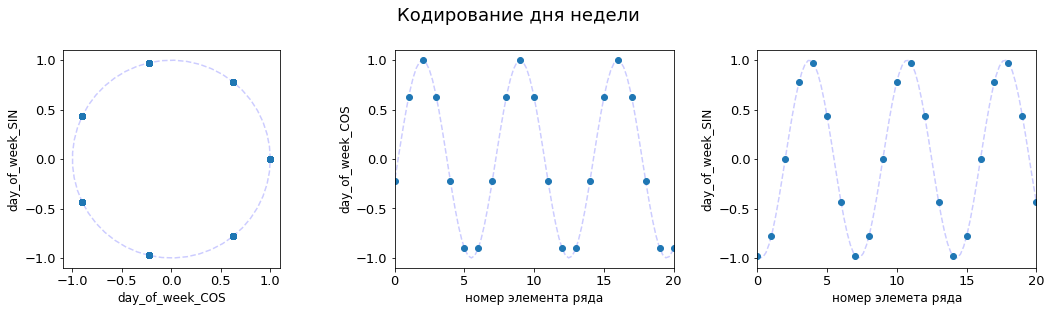

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(18,4))
fig.suptitle('Кодирование дня недели', y=1.03)
fig.subplots_adjust(wspace=0.3)

x = np.linspace(0, np.pi * 2)
axs[0].plot(np.cos(x), np.sin(x), 'b--', alpha=0.2)
axs[0].plot(dow['DoW_cos'], dow['DoW_sin'], 'o')
axs[0].set_box_aspect(1)
axs[0].set_xlabel('day_of_week_COS')
axs[0].set_ylabel('day_of_week_SIN')

x = np.linspace(-3, 20, 100)
axs[1].plot(x + 2, np.cos(x * np.pi * 2 / 7), 
            'b--', alpha=0.2)
axs[1].plot(dow['DoW_cos'], 'o')
axs[1].set_xlim(0, 20)
axs[1].set_xlabel('номер элемента ряда')
axs[1].set_ylabel('day_of_week_COS')

x = np.linspace(-3, 20, 100)
axs[2].plot(x + 2, np.sin(x * np.pi * 2 / 7), 
            'b--', alpha=0.2)
axs[2].plot(dow['DoW_sin'], 'o')
axs[2].set_xlim(0, 20)
axs[2].set_xlabel('номер элемета ряда')
axs[2].set_ylabel('day_of_week_SIN')

plt.show()

## Дата - месяц, день
циклические признаки

Кодируются аналогичным дню недели образом.

In [21]:
def preprocess_date(data):
    parse_date = lambda x: [int(x['Date'][:x['Date'].find('.')]), 
                            int(x['Date'][x['Date'].find('.') + 1 : x['Date'].rfind('.')])]

    day_month = data.apply(parse_date, axis=1, result_type='expand')

    day_encoded = encode_cyclic(day_month[0], 'day')
    month_encoded = encode_cyclic(day_month[1], 'month')
    
    return day_encoded, month_encoded

In [22]:
day_encoded, month_encoded = preprocess_date(train)

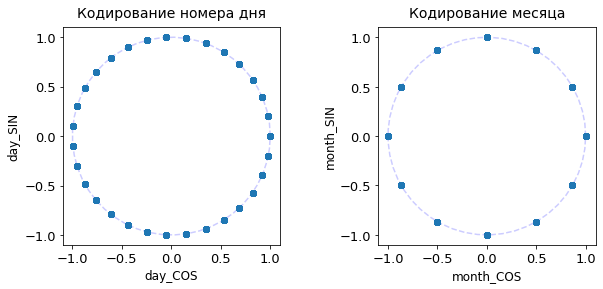

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
fig.subplots_adjust(wspace=0.3)

x = np.linspace(0, np.pi * 2)
axs[0].plot(np.cos(x), np.sin(x), 'b--', alpha=0.2)
axs[0].plot(day_encoded['day_cos'], day_encoded['day_sin'], 'o')
axs[0].set_box_aspect(1)
axs[0].set_xlabel('day_COS')
axs[0].set_ylabel('day_SIN')
axs[0].set_title('Кодирование номера дня', pad=10)

axs[1].plot(np.cos(x), np.sin(x), 'b--', alpha=0.2)
axs[1].plot(month_encoded['month_cos'], month_encoded['month_sin'], 'o')
axs[1].set_box_aspect(1)
axs[1].set_xlabel('month_COS')
axs[1].set_ylabel('month_SIN')
axs[1].set_title('Кодирование месяца', pad=10)

plt.show()

## Тип дня, время года
бинарные признаки


In [24]:
def preprocess_tod(data):
    return data['Type of day'] - 1

In [25]:
def preprocess_wst(data):
    return data['Winter-summer time'] - 1

In [26]:
tod, wst = preprocess_tod(train), preprocess_wst(train)

# Объединение признаков

In [27]:
train_processed = pd.DataFrame()

train_processed['E'] = e_avg_std
train_processed['T'] = t_avg_std
train_processed['TOD'] = tod
train_processed['WST'] = wst
train_processed = pd.concat([train_processed, ft_std, dow, day_encoded, month_encoded], 
                            axis=1)

print(train_processed)

             E         T  TOD  WST       FT4      FT10      FT16      FT22  \
0    -0.350721 -1.476255    1    0 -1.525302 -1.435333 -1.488854 -1.469770   
1    -0.086256 -1.711234    1    0 -1.902433 -1.771823 -1.718839 -1.555847   
2     0.157930 -2.115659    1    0 -1.902433 -1.940068 -1.948823 -2.072306   
3     0.482281 -2.066057    1    0 -2.090998 -2.276557 -2.332131 -2.502689   
4     0.438077 -1.621804    1    0 -2.279563 -2.360680 -2.408792 -2.416613   
...        ...       ...  ...  ...       ...       ...       ...       ...   
1821  1.260136 -1.316947    0    0 -1.431020 -1.351211 -1.335531 -1.383693   
1822  1.221309 -1.462134    0    0 -1.431020 -1.435333 -1.488854 -1.297617   
1823  1.754005 -1.817319    0    0 -1.431020 -1.435333 -1.412193 -1.469770   
1824  1.726597 -1.925938    0    0 -1.525302 -1.603578 -1.718839 -1.728000   
1825  1.293371 -1.638821    0    0 -1.996715 -1.519455 -1.258870 -1.125464   

           DoW_sin   DoW_cos       day_sin   day_cos     month_

# Тестовая выборка

Точность прогнозирования моделей будет оцениваться путем сравнения с показателями за последний год наблюдений.

In [28]:
_, test_e, _ = preprocess_e(test, e_params)
_, test_t, _ = preprocess_t(test, t_params)
test_tod = preprocess_tod(test)
test_wst = preprocess_wst(test)
_, test_ft, _ = preprocess_ft(test, ft_params)
test_dow = preprocess_dow(test)
test_day, test_month = preprocess_date(test)

In [29]:
test_processed = pd.DataFrame()

test_processed['E'] = test_e
test_processed['T'] = test_t
test_processed['TOD'] = test_tod
test_processed['WST'] = test_wst
test_processed = pd.concat([test_processed, test_ft, test_dow, test_day, test_month], 
                            axis=1)

In [30]:
print(test_processed)

             E         T  TOD  WST       FT4      FT10      FT16      FT22  \
1826  0.112969 -0.750679    1    0 -0.959607 -0.762354 -0.722239 -0.609004   
1827  0.105578 -0.469355    1    0 -0.393911 -0.509986 -0.645577 -0.436851   
1828  0.151155 -0.408529    1    0 -0.205346 -0.425864 -0.645577 -0.522927   
1829  0.236507 -0.538147    1    0 -0.393911 -0.594109 -0.798900 -0.695080   
1830  0.573626 -1.408187    1    0 -1.053889 -1.182966 -1.335531 -1.383693   
...        ...       ...  ...  ...       ...       ...       ...       ...   
2186  0.567917 -0.782178    0    0 -0.582476 -0.762354 -0.952223 -0.781157   
2187  1.233154 -1.110570    0    0 -0.771042 -0.846476 -1.028885 -0.867234   
2188  1.377918 -1.326360    0    0 -1.242455 -1.182966 -1.182208 -1.211540   
2189  1.266082 -1.155828    0    0 -1.336737 -1.267088 -1.335531 -1.211540   
2190  0.863107 -1.412169    0    0 -1.242455 -1.267088 -1.335531 -1.555847   

           DoW_sin   DoW_cos       day_sin   day_cos     month_

# Сохранение данных

In [31]:
import pickle

with open('../data/var1.pkl', 'wb') as file:
    pickle.dump([train_processed, test_processed, e_params, t_params, ft_params], file)